In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pickle
import tensorflow as tf
import tensorflow_io as tfio
import os
import sys
from numpy import argmax

sys.path.insert(0, '../VisualizationTools')
import get_data_from_XML, get_gt, getUID, roi2rect, utils, visualization

from sklearn.metrics import f1_score, mean_squared_error, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping

In [2]:
tf.__version__

'2.9.1'

In [3]:
#Convert a numpy 3d array of a bitmap of an rgb image to grayscale
#using the formula (0.3 * R) + (0.59 * G) + (0.11 * B) 
def rgb_bmp_togray(imgbmp):
    r = imgbmp[:,:,0]
    g = imgbmp[:,:,1]
    b = imgbmp[:,:,2]
    graybmp = np.multiply(0.3*r, 0.59*g)
    graybmp = np.multiply(graybmp, .11*b)
    
    return graybmp

#Intersection over union calculation given two bounding boxes
def IOU(bbox1, bbox2):
    xmin1, ymin1, xmax1, ymax1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    xmin2, ymin2, xmax2, ymax2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    x_intersection = 0
    if xmin1 <= xmax2 and xmin2 <= xmax1:
        x_intersection = min(xmax1, xmax2) - max(xmin1, xmin2)
        
    y_intersection = 0
    if ymin1 <= ymax2 and ymin2 <= ymax1:
        y_intersection = min(ymax1, ymax2) - max(ymin1, ymin2)
    
    intersection = x_intersection * y_intersection
    
    if intersection == 0:
        return 0
    
    union = (xmax1-xmin1)*(ymax1-ymin1) + (xmax2-xmin2)*(ymax2-ymin2) - intersection
    
    return intersection/union

    return I / U

dicom_path = '../images/smallTraining/'
annotation_path = '../annot/Annotation/'

anfilenames = os.listdir(annotation_path)
lungfilenames = os.listdir(dicom_path)
num_classes = 4
xtotal = []
ybox = []
yclass = []
for aname in anfilenames:
    #if np.random.random() > .1:
    #    continue
    anpath = annotation_path + aname
    lungpath = dicom_path + "Lung_Dx-" + aname
    if not os.path.isdir(lungpath):
        print("missing: ", lungpath)
        continue
    lungs = getUID.getUID_path(lungpath)
    annotations = get_data_from_XML.XML_preprocessor(anpath, num_classes=num_classes).data
    for k, v in annotations.items():
        
        key = k[:-4]
        if key not in lungs:
            print("missing key: ", k)
            continue
        dcm_path, dcm_name = lungs[k[:-4]]
        matrix, frame_num, width, height, ch = utils.loadFile(dcm_path)
        img_bitmap = utils.MatrixToImage(matrix[0], ch)
        xbmp = img_bitmap
        if len(img_bitmap.shape) > 2: #assume bitmap is rgb
            xbmp = rgb_bmp_togray(img_bitmap)
        xbmp = xbmp.reshape(np.prod(xbmp.shape))/255
        #xbmp = xbmp.reshape(512, 512, 1)
        #xbmp = np.resize(xbmp, (256, 256))
        xtotal.append(xbmp)

        #extract xmin, ymin, xmax, ymax in that order
        ybox.append(np.array([v[0][0], v[0][1], v[0][2], v[0][3]]))
        yclass.append(np.array([v[0][4], v[0][5], v[0][6], v[0][7]]))
    

        
        
        
xtotal = np.array(xtotal)
ybox = np.array(ybox)
yclass = np.array(yclass)

missing:  ../images/smallTraining/Lung_Dx-A0001
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.131943461111501120339653486778.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.178836002044492899997583802620.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.298515116091921420006643787707.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.353855695020176158431198172735.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.386936544335940634104504855125.xml
missing:  ../images/smallTraining/Lung_Dx-A0005
missing:  ../images/smallTraining/Lung_Dx-A0006
missing:  ../images/smallTraining/Lung_Dx-A0007
missing:  ../images/smallTraining/Lung_Dx-A0008
missing:  ../images/smallTraining/Lung_Dx-A0009
missing:  ../images/smallTraining/Lung_Dx-A0010
missing:  ../images/smallTraining/Lung_Dx-A0011
missing:  ../images/smallTraining/Lung_Dx-A0012
missing:  ../images/smallTraining/Lung_Dx-A0013
missing:  ../images/smallTraining/Lung_Dx-A0014
missing:  ../images/smallTraining/Lung_Dx-A0015
missing: 

-----

## Testing set creation

In [134]:
testing_dicom_path = '../images/testImages/'

anfilenames = os.listdir(annotation_path)
lungfilenames = os.listdir(dicom_path)
num_classes = 4
xtesting = []
ytestingbox = []
ytestingclass = []
for aname in anfilenames:
    #if np.random.random() > .1:
    #    continue
    anpath = annotation_path + aname
    lungpath = testing_dicom_path + "Lung_Dx-" + aname
    if not os.path.isdir(lungpath):
        print("missing: ", lungpath)
        continue
    lungs = getUID.getUID_path(lungpath)
    annotations = get_data_from_XML.XML_preprocessor(anpath, num_classes=num_classes).data
    for k, v in annotations.items():
        
        key = k[:-4]
        if key not in lungs:
            print("missing key: ", k)
            continue
        dcm_path, dcm_name = lungs[k[:-4]]
        matrix, frame_num, width, height, ch = utils.loadFile(dcm_path)
        img_bitmap = utils.MatrixToImage(matrix[0], ch)
        xbmp = img_bitmap
        if len(img_bitmap.shape) > 2: #assume bitmap is rgb
            xbmp = rgb_bmp_togray(img_bitmap)
        xbmp = xbmp.reshape(np.prod(xbmp.shape))/255
        #xbmp = xbmp.reshape(512, 512, 1)
        #xbmp = np.resize(xbmp, (256, 256))
        xtesting.append(xbmp)

        #extract xmin, ymin, xmax, ymax in that order
        ytestingbox.append(np.array([v[0][0], v[0][1], v[0][2], v[0][3]]))
        ytestingclass.append(np.array([v[0][4], v[0][5], v[0][6], v[0][7]]))
    

        
        
        
xtesting = np.array(xtesting)
ytestingbox = np.array(ytestingbox)
ytestingclass = np.array(ytestingclass)

missing:  ../images/testImages/Lung_Dx-A0001
missing:  ../images/testImages/Lung_Dx-A0002
missing:  ../images/testImages/Lung_Dx-A0003
missing:  ../images/testImages/Lung_Dx-A0004
missing:  ../images/testImages/Lung_Dx-A0005
missing:  ../images/testImages/Lung_Dx-A0006
missing:  ../images/testImages/Lung_Dx-A0007
missing:  ../images/testImages/Lung_Dx-A0008
missing:  ../images/testImages/Lung_Dx-A0010
missing:  ../images/testImages/Lung_Dx-A0011
missing:  ../images/testImages/Lung_Dx-A0012
missing:  ../images/testImages/Lung_Dx-A0013
missing:  ../images/testImages/Lung_Dx-A0014
missing:  ../images/testImages/Lung_Dx-A0015
missing:  ../images/testImages/Lung_Dx-A0016
missing:  ../images/testImages/Lung_Dx-A0017
missing:  ../images/testImages/Lung_Dx-A0018
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.100199112995438635843231609895.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.105992484897188335200317273098.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.114195197433907040510

----

### Train test splitting

In [6]:
X_train, X_test, y_train_box, y_test_box, y_train_class, y_test_class = train_test_split(xtotal, ybox, yclass, random_state = 2022)

In [7]:
es = EarlyStopping(patience = 50)

-----------------------------

### Bounding box predictor model

In [8]:
simple_keras = Sequential()

#simple_keras.add(Conv2D(32, (7,7), activation = 'relu', input_shape = (256, 256, 1)))
#simple_keras.add(MaxPool2D(pool_size = (2, 2)))

#simple_keras.add(Flatten())
simple_keras.add(Dense(200, input_dim = X_train.shape[-1], activation = 'relu'))
#simple_keras.add(Dense(200, activation = 'relu'))

simple_keras.add(Dropout(0.2))

simple_keras.add(Dense(y_train_box.shape[-1]))

In [9]:
simple_keras.compile('adadelta', 'mse')
simple_keras.fit(X_train, y_train_box, epochs=1500, validation_data=(X_test, y_test_box), verbose=2, callbacks = es)

Epoch 1/1500
22/22 - 3s - loss: 77791.6250 - val_loss: 77163.4531 - 3s/epoch - 125ms/step
Epoch 2/1500
22/22 - 1s - loss: 74590.2734 - val_loss: 74928.1172 - 807ms/epoch - 37ms/step
Epoch 3/1500
22/22 - 1s - loss: 72495.9219 - val_loss: 72888.5156 - 789ms/epoch - 36ms/step
Epoch 4/1500
22/22 - 1s - loss: 70618.5859 - val_loss: 70999.6719 - 813ms/epoch - 37ms/step
Epoch 5/1500
22/22 - 1s - loss: 69040.6484 - val_loss: 69433.5234 - 811ms/epoch - 37ms/step
Epoch 6/1500
22/22 - 1s - loss: 67732.5156 - val_loss: 68015.0234 - 804ms/epoch - 37ms/step
Epoch 7/1500
22/22 - 1s - loss: 66200.5000 - val_loss: 66952.6250 - 803ms/epoch - 36ms/step
Epoch 8/1500
22/22 - 1s - loss: 64973.9297 - val_loss: 65336.9414 - 789ms/epoch - 36ms/step
Epoch 9/1500
22/22 - 1s - loss: 63509.5938 - val_loss: 63979.1211 - 815ms/epoch - 37ms/step
Epoch 10/1500
22/22 - 1s - loss: 62207.2891 - val_loss: 62610.9180 - 808ms/epoch - 37ms/step
Epoch 11/1500
22/22 - 1s - loss: 61029.7852 - val_loss: 61277.0312 - 795ms/epoch 

-------------------

## Class predictor model (classification) using bounding box locations

In [13]:
classES = EarlyStopping(patience = 10)

In [10]:
pd.DataFrame(y_test_class).value_counts(normalize = True) #Baseline classification, should see an accuracy of about 30.6% if we only guess highest occuring within this dataset

0    1    2    3  
0.0  0.0  0.0  1.0    0.306034
     1.0  0.0  0.0    0.306034
1.0  0.0  0.0  0.0    0.301724
0.0  0.0  1.0  0.0    0.086207
dtype: float64

In [36]:
class_keras = Sequential()

class_keras.add(Dense(100, input_dim = y_train_box.shape[-1], activation = 'relu'))

class_keras.add(Dropout(0.2))

#class_keras.add(Dense(50, activation = 'relu'))

class_keras.add(Dense(y_train_class.shape[-1], activation = 'sigmoid'))

In [37]:
class_keras.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
class_keras.fit(y_train_box, y_train_class, epochs=1000, validation_data=(y_test_box, y_test_class), verbose=2, callbacks = classES)

Epoch 1/1000
22/22 - 0s - loss: 62.4913 - val_loss: 14.1168 - 468ms/epoch - 21ms/step
Epoch 2/1000
22/22 - 0s - loss: 32.0608 - val_loss: 17.2600 - 100ms/epoch - 5ms/step
Epoch 3/1000
22/22 - 0s - loss: 27.8823 - val_loss: 8.8973 - 90ms/epoch - 4ms/step
Epoch 4/1000
22/22 - 0s - loss: 23.9886 - val_loss: 4.6274 - 93ms/epoch - 4ms/step
Epoch 5/1000
22/22 - 0s - loss: 18.5154 - val_loss: 7.3741 - 116ms/epoch - 5ms/step
Epoch 6/1000
22/22 - 0s - loss: 17.5057 - val_loss: 5.3574 - 89ms/epoch - 4ms/step
Epoch 7/1000
22/22 - 0s - loss: 15.7528 - val_loss: 4.4748 - 97ms/epoch - 4ms/step
Epoch 8/1000
22/22 - 0s - loss: 12.3208 - val_loss: 4.1966 - 88ms/epoch - 4ms/step
Epoch 9/1000
22/22 - 0s - loss: 11.1213 - val_loss: 3.6459 - 94ms/epoch - 4ms/step
Epoch 10/1000
22/22 - 0s - loss: 9.3576 - val_loss: 3.3985 - 116ms/epoch - 5ms/step
Epoch 11/1000
22/22 - 0s - loss: 8.4956 - val_loss: 4.0731 - 98ms/epoch - 4ms/step
Epoch 12/1000
22/22 - 0s - loss: 6.6478 - val_loss: 2.5823 - 93ms/epoch - 4ms/st

----------

### Validation and analysis of bounding box predictor

In [54]:
ypred = simple_keras.predict(X_test)
for box in ypred:
    if box[0] > box[2]:
        temp = box[0]
        box[0] = box[2]
        box[2] = temp
    if box[1] > box[3]:
        temp = box[1]
        box[1] = box[3]
        box[3] = box[1]

8/8 [==============================] - 0s 19ms/step


In [55]:
ious = [IOU(ypred[i], y_test_box[i]) for i in range(len(y_test_box))]
imin = ious.index(min(ious))
print("Max IOU:", max(ious))
print("Min IOU:",min(ious))
print("Total testing length:", len(ious))
print(IOU(ypred[imin], y_test_box[imin]))
print("Average IOU: {}".format(sum(ious)/len(ious)))
hitious = [iou for iou in ious if iou != 0]
print("Total nonzero IOUs:", len(hitious))
print("Average IOU without misses: {}".format(sum(hitious)/len(hitious)))

Max IOU: 0.9009699157804222
Min IOU: 0
Total testing length: 232
0
Average IOU: 0.29083896840716267
Total nonzero IOUs: 179
Average IOU without misses: 0.37695329983498177


## Testing on different set

In [135]:
ytestingpred = simple_keras.predict(xtesting)
for box in ypred:
    if box[0] > box[2]:
        temp = box[0]
        box[0] = box[2]
        box[2] = temp
    if box[1] > box[3]:
        temp = box[1]
        box[1] = box[3]
        box[3] = box[1]

59/59 [==============================] - 1s 16ms/step


In [136]:
testingious = [IOU(ytestingpred[i], ytestingbox[i]) for i in range(len(ytestingbox))]
testingimin = ious.index(min(testingious))
print("Max IOU:", max(testingious))
print("Min IOU:",min(testingious))
print("Total testing length:", len(testingious))
print(IOU(ytestingpred[imin], ytestingbox[imin]))
print("Average IOU: {}".format(sum(ious)/len(ious)))
testinghitious = [iou for iou in testingious if iou != 0]
print("Total nonzero IOUs:", len(testinghitious))
print("Average IOU without misses: {}".format(sum(testinghitious)/len(testinghitious)))

Max IOU: 0.8609153271376075
Min IOU: 0
Total testing length: 1861
0.37752175395220783
Average IOU: 0.29083896840716267
Total nonzero IOUs: 401
Average IOU without misses: 0.2139121222263412


---------

## Class classification by Bounding Box analysis

In [57]:
classpreds = argmax(class_keras.predict(y_test_box), axis = -1)

8/8 [==============================] - 0s 1ms/step


In [58]:
f1_score(argmax(y_test_class, axis = -1), classpreds, average = None)

array([0.83018868, 0.66666667, 0.51282051, 0.67132867])

In [119]:
f1_score(argmax(y_test_class, axis = -1), classpreds, average = 'weighted')

0.7041693396605563

In [59]:
multilabel_confusion_matrix(argmax(y_test_class, axis=-1).astype('int'), classpreds)

array([[[139,  23],
        [  4,  66]],

       [[150,  11],
        [ 30,  41]],

       [[203,   9],
        [ 10,  10]],

       [[137,  24],
        [ 23,  48]]], dtype=int64)

In [91]:
# turn argmax data into array of classifications for labeling bounding boxes
classpredsar = []
for value in classpreds:
    if value == 0:
        classpredsar.append([1,0,0,0])
    elif value == 1:
        classpredsar.append([0,1,0,0])
    elif value == 2:
        classpredsar.append([0,0,1,0])
    else:
        classpredsar.append([0,0,0,1])
    

## On a different test set

In [137]:
testingclasspreds = argmax(class_keras.predict(ytestingbox), axis = -1)

59/59 [==============================] - 0s 1ms/step


In [138]:
f1_score(argmax(ytestingclass, axis = -1), testingclasspreds, average = 'weighted')

0.40178100521718946

In [139]:
f1_score(argmax(ytestingclass, axis = -1), testingclasspreds, average = None)

array([0.34926471, 0.13888889, 0.38461538, 0.46780552])

In [140]:
multilabel_confusion_matrix(argmax(ytestingclass, axis=-1).astype('int'), testingclasspreds)

array([[[ 514,  860],
        [ 202,  285]],

       [[1526,  163],
        [ 147,   25]],

       [[1693,   65],
        [  63,   40]],

       [[ 695,   67],
        [ 743,  356]]], dtype=int64)

In [141]:
# turn argmax data into array of classifications for labeling bounding boxes
testingclasspredsar = []
for value in testingclasspreds:
    if value == 0:
        testingclasspredsar.append([1,0,0,0])
    elif value == 1:
        testingclasspredsar.append([0,1,0,0])
    elif value == 2:
        testingclasspredsar.append([0,0,1,0])
    else:
        testingclasspredsar.append([0,0,0,1])
    

--------------

## Using image data to predict class model

In [68]:
X_class_keras = Sequential()

X_class_keras.add(Dense(100, input_dim = X_train.shape[-1], activation = 'relu'))

X_class_keras.add(Dropout(0.2))

#X_class_keras.add(Dense(50, activation = 'relu'))

X_class_keras.add(Dense(y_train_class.shape[-1], activation = 'sigmoid'))

In [69]:
X_class_keras.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
X_class_keras.fit(X_train, y_train_class, epochs=1000, validation_data=(X_test, y_test_class), verbose=2, callbacks = classES)

Epoch 1/1000
22/22 - 1s - loss: 176.1244 - val_loss: 12.2687 - 1s/epoch - 55ms/step
Epoch 2/1000
22/22 - 1s - loss: 5.7468 - val_loss: 2.1288 - 530ms/epoch - 24ms/step
Epoch 3/1000
22/22 - 1s - loss: 24.2424 - val_loss: 0.1543 - 522ms/epoch - 24ms/step
Epoch 4/1000
22/22 - 1s - loss: 5.8515 - val_loss: 1.8403 - 527ms/epoch - 24ms/step
Epoch 5/1000
22/22 - 1s - loss: 6.3091 - val_loss: 0.3195 - 533ms/epoch - 24ms/step
Epoch 6/1000
22/22 - 1s - loss: 1.2692 - val_loss: 0.2744 - 532ms/epoch - 24ms/step
Epoch 7/1000
22/22 - 1s - loss: 0.4960 - val_loss: 0.0305 - 520ms/epoch - 24ms/step
Epoch 8/1000
22/22 - 1s - loss: 0.1071 - val_loss: 0.0486 - 508ms/epoch - 23ms/step
Epoch 9/1000
22/22 - 1s - loss: 0.1388 - val_loss: 0.0307 - 507ms/epoch - 23ms/step
Epoch 10/1000
22/22 - 1s - loss: 0.0866 - val_loss: 0.0385 - 516ms/epoch - 23ms/step
Epoch 11/1000
22/22 - 1s - loss: 0.1043 - val_loss: 0.0310 - 520ms/epoch - 24ms/step
Epoch 12/1000
22/22 - 1s - loss: 0.0941 - val_loss: 0.0266 - 514ms/epoch 

--------

## Preds with using image data to predict class

In [70]:
Xclasspreds = argmax(X_class_keras.predict(X_test), axis = -1)

8/8 [==============================] - 0s 11ms/step


In [71]:
f1_score(argmax(y_test_class, axis = -1), Xclasspreds, average = None)

array([0.95890411, 0.95945946, 0.88888889, 0.94029851])

In [120]:
f1_score(argmax(y_test_class, axis = -1), Xclasspreds, average = 'weighted')

0.9473443150882888

In [72]:
multilabel_confusion_matrix(argmax(y_test_class, axis=-1).astype('int'), Xclasspreds)

array([[[156,   6],
        [  0,  70]],

       [[155,   6],
        [  0,  71]],

       [[212,   0],
        [  4,  16]],

       [[161,   0],
        [  8,  63]]], dtype=int64)

In [87]:
# turn argmax data into array of classifications for labeling bounding boxes
Xclasspredsar = []
for value in Xclasspreds:
    if value == 0:
        Xclasspredsar.append([1,0,0,0])
    elif value == 1:
        Xclasspredsar.append([0,1,0,0])
    elif value == 2:
        Xclasspredsar.append([0,0,1,0])
    else:
        Xclasspredsar.append([0,0,0,1])
    

## On a different test set

In [161]:
Xtotalclasspreds = argmax(X_class_keras.predict(xtesting), axis = -1)

59/59 [==============================] - 1s 12ms/step


In [162]:
f1_score(argmax(ytestingclass, axis = -1), Xtotalclasspreds, average = None)

array([0.58311346, 0.4205379 , 0.10738255, 0.43095397])

In [163]:
f1_score(argmax(ytestingclass, axis = -1), Xtotalclasspreds, average = 'weighted')

0.45190090628424234

In [164]:
multilabel_confusion_matrix(argmax(ytestingclass, axis=-1).astype('int'), Xtotalclasspreds)

array([[[ 787,  587],
        [  45,  442]],

       [[1538,  151],
        [  86,   86]],

       [[1579,  179],
        [  87,   16]],

       [[ 685,   77],
        [ 776,  323]]], dtype=int64)

In [165]:
# turn argmax data into array of classifications for labeling bounding boxes
Xtotalclasspredsar = []
for value in Xtotalclasspreds:
    if value == 0:
        Xtotalclasspredsar.append([1,0,0,0])
    elif value == 1:
        Xtotalclasspredsar.append([0,1,0,0])
    elif value == 2:
        Xtotalclasspredsar.append([0,0,1,0])
    else:
        Xtotalclasspredsar.append([0,0,0,1])
    

## Images and IOUS score

IOU score: 0.9009699157804222
[array([140.51396179, 261.67993164, 201.09358215, 310.26324463,
         1.        ,   0.        ,   0.        ,   0.        ])]


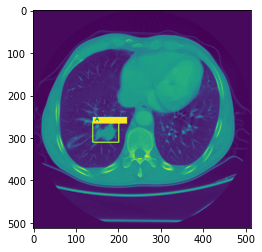

In [97]:
imax = ious.index(max(ious))
print('IOU score: ' + str(ious[imax]))
data = [np.hstack((np.asarray(ypred[imax]), classpredsar[imax]))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasBestPred.png')

IOU score: 0.9009699157804222
[array([140.51396179, 261.67993164, 201.09358215, 310.26324463,
         0.        ,   1.        ,   0.        ,   0.        ])]


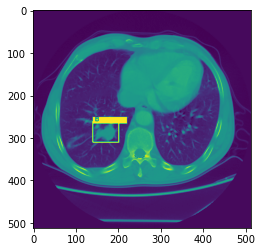

In [98]:
print('IOU score: ' + str(ious[imax]))
data = [np.hstack((np.asarray(ypred[imax]), Xclasspredsar[imax]))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/XkerasBestPred.png')

IOU score: 0.9009699157804222
[array([136., 262., 201., 309.,   0.,   1.,   0.,   0.])]


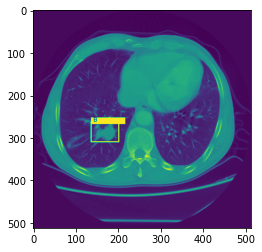

In [99]:
print('IOU score: ' + str(ious[imax]))
data = [np.hstack((np.asarray(y_test_box[imax]), y_test_class[imax]))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasActualBestPred.png')

IOU score: 0
[157. 336. 215. 385.] [152.57928 201.12523 203.66895 265.32635]


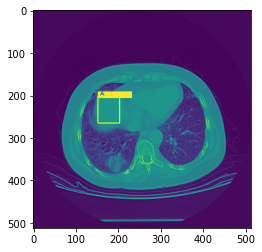

In [100]:
imin = ious.index(min(ious))
print('IOU score: ' + str(ious[imin]))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), classpredsar[imin]))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasWorstPred.png')

IOU score: 0
[157. 336. 215. 385.] [152.57928 201.12523 203.66895 265.32635]


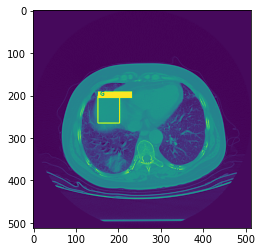

In [101]:
print('IOU score: ' + str(ious[imin]))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), Xclasspredsar[imin]))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/XkerasWorstPred.png')

IOU score: 0
[157. 336. 215. 385.] [152.57928 201.12523 203.66895 265.32635]


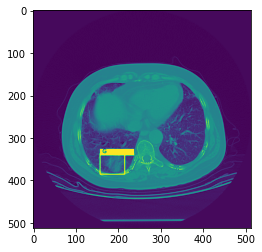

In [102]:
print('IOU score: ' + str(ious[imin]))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(y_test_box[imin]), y_test_class[imin]))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasActualWorstPred.png')

IOU score: 0.4546999907001838
[309. 365. 363. 405.] [309.56204 372.10208 372.6783  426.98932]


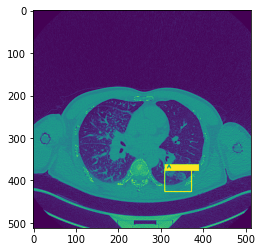

In [103]:
imin = hitious.index(min(hitious))
print('IOU score: ' + str(ious[imin]))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), classpredsar[imin]))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/kerasMediumPred.png')

IOU score: 0.4546999907001838
[309. 365. 363. 405.] [309.56204 372.10208 372.6783  426.98932]


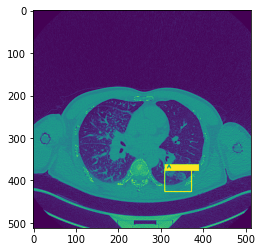

In [104]:
print('IOU score: ' + str(ious[imin]))
print(y_test_box[imin], (ypred[imin]))
data = [np.hstack((np.asarray(ypred[imin]), Xclasspredsar[imin]))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/XkerasMediumPred.png')

IOU score: 0.4546999907001838
[309. 365. 363. 405.] [309.56204 372.10208 372.6783  426.98932]


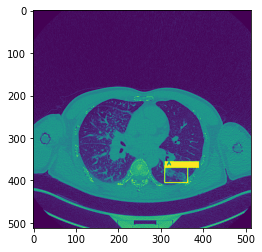

In [105]:
print('IOU score: ' + str(ious[imin]))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(y_test_box[imin]), y_test_class[imin]))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/kerasActualMediumPred.png')

----

## On a different set

IOU score: 0.8609153271376075
[array([173.42547607, 223.27864075, 235.03904724, 290.17132568,
         0.        ,   0.        ,   0.        ,   1.        ])]


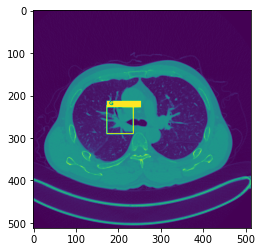

In [153]:
imax = testingious.index(max(testingious))
print('IOU score: ' + str(testingious[imax]))
data = [np.hstack((np.asarray(ytestingpred[imax]), testingclasspredsar[imax]))]
img_bitmap = xtesting[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/validationBestPred.png')

IOU score: 0.8609153271376075
[array([173.42547607, 223.27864075, 235.03904724, 290.17132568,
         1.        ,   0.        ,   0.        ,   0.        ])]


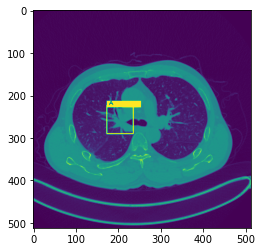

In [167]:
print('IOU score: ' + str(testingious[imax]))
data = [np.hstack((np.asarray(ytestingpred[imax]), Xtotalclasspredsar[imax]))]
img_bitmap = xtesting[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/XvalidationBestPred.png')

IOU score: 0.8609153271376075
[array([176., 218., 234., 289.,   0.,   0.,   0.,   1.])]


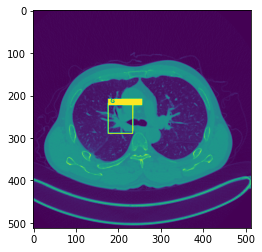

In [154]:
print('IOU score: ' + str(testingious[imax]))
data = [np.hstack((np.asarray(ytestingbox[imax]), ytestingclass[imax]))]
img_bitmap = xtesting[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/validationActualBestPred.png')

IOU score: 0.21299278118163684
[131. 242. 254. 345.] [149.41284 232.64009 200.97517 296.32648]


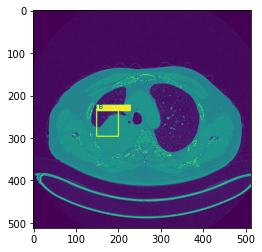

In [157]:
imin = testinghitious.index(max(testinghitious))
print('IOU score: ' + str(testingious[imin]))
print(ytestingbox[imin], ytestingpred[imin])
data = [np.hstack((np.asarray(ytestingpred[imin]), testingclasspredsar[imin]))]
img_bitmap = xtesting[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/validationMediumPred.png')

IOU score: 0.21299278118163684
[131. 242. 254. 345.] [149.41284 232.64009 200.97517 296.32648]


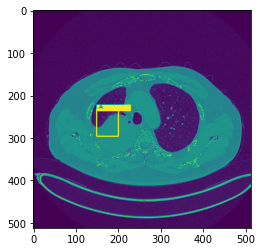

In [166]:
print('IOU score: ' + str(testingious[imin]))
print(ytestingbox[imin], ytestingpred[imin])
data = [np.hstack((np.asarray(ytestingpred[imin]), Xtotalclasspredsar[imin]))]
img_bitmap = xtesting[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/XvalidationMediumPred.png')

IOU score: 0.21299278118163684


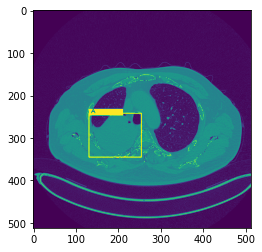

In [158]:
print('IOU score: ' + str(testingious[imin]))
data = [np.hstack((np.asarray(ytestingbox[imin]), ytestingclass[imin]))]
img_bitmap = xtesting[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/validationActualMediumPred.png')